In [ ]:
# Importing Libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
from scipy.fftpack import dct, idct

In [ ]:
# Task 1: Image Compression

# Apply DCT to an image block
def apply_dct(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

# Apply inverse DCT to an image block
def apply_idct(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

# Perform DCT-based compression with 2x2 quantization matrix
def compress_dct(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    h, w = image.shape

    # Padding to make dimensions multiple of 8
    h_pad = (8 - h % 8) % 8
    w_pad = (8 - w % 8) % 8
    padded_image = np.pad(image, ((0, h_pad), (0, w_pad)), mode='constant', constant_values=0)

    compressed_image = np.zeros_like(padded_image, dtype=np.float32)

    # 2x2 Quantization matrix
    Q = np.array([
        [16, 11],
        [12, 12]
    ])

    # Process 8x8 blocks
    for i in range(0, padded_image.shape[0], 8):
        for j in range(0, padded_image.shape[1], 8):
            block = padded_image[i:i+8, j:j+8]
            dct_block = apply_dct(block)

            # Apply 2x2 quantization on the top-left corner of the DCT block
            quantized_block = dct_block.copy()
            for qi in range(2):
                for qj in range(2):
                    quantized_block[qi, qj] = np.round(dct_block[qi, qj] / Q[qi, qj]) * Q[qi, qj]

            idct_block = apply_idct(quantized_block)
            compressed_image[i:i+8, j:j+8] = idct_block

    # Clip values to valid range
    compressed_image = np.clip(compressed_image, 0, 255).astype(np.uint8)

    return image, compressed_image
# Plot Original and Compressed Images
def plot_images(original, compressed, title1="Original", title2="Compressed"):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title(title1)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(compressed, cv2.COLOR_BGR2RGB))
    plt.title(title2)
    plt.axis('off')
    plt.show()


In [ ]:
# Task 2: CNN Implementation

def build_cnn(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Evaluation Metrics
def evaluate_model(y_true, y_pred, y_probs, classes):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_probs[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    print(f"Accuracy: {acc}")
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")
    print(f"F1-Score: {f1}")

    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Training on MNIST
def train_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255
    y_train = to_categorical(y_train, 10)
    y_test_cat = to_categorical(y_test, 10)

    model = build_cnn((28, 28, 1), 10)
    model.fit(x_train, y_train, epochs=50, batch_size=128, validation_split=0.2)

    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    evaluate_model(y_test, y_pred, y_pred_probs, list(range(10)))

# Training on CIFAR-10
def train_cifar10():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = to_categorical(y_train, 10)
    y_test_cat = to_categorical(y_test, 10)

    model = build_cnn((32, 32, 3), 10)
    model.fit(x_train, y_train, epochs=50, batch_size=128, validation_split=0.2)

    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    evaluate_model(y_test.flatten(), y_pred, y_pred_probs, list(range(10)))

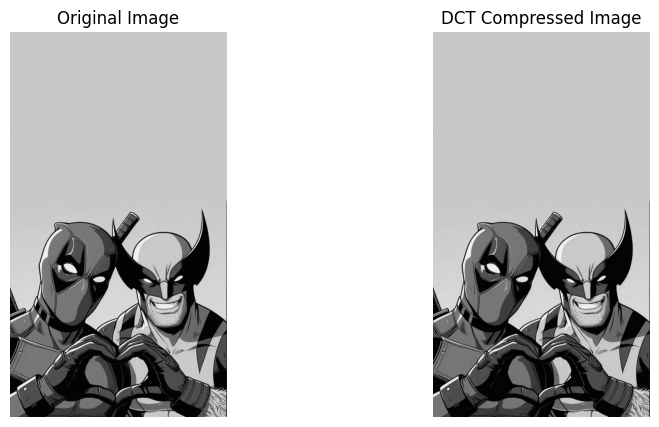


Training CNN on MNIST Dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7738 - loss: 0.6994 - val_accuracy: 0.9799 - val_loss: 0.0661
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9728 - loss: 0.0921 - val_accuracy: 0.9865 - val_loss: 0.0467
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9817 - loss: 0.0615 - val_accuracy: 0.9889 - val_loss: 0.0382
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9854 - loss: 0.0487 - val_accuracy: 0.9881 - val_loss: 0.0439
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9880 - loss: 0.0393 - val_accuracy: 0.9903 - val_loss: 0.0368
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9909 - loss: 0.0306 - val_accuracy: 0.9908 - val_loss: 0.0332
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9920 - loss: 0.0279 - val_accuracy: 0.9907 - val_loss: 0.0343
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9932 - loss: 0.0235 - val_accuracy: 0

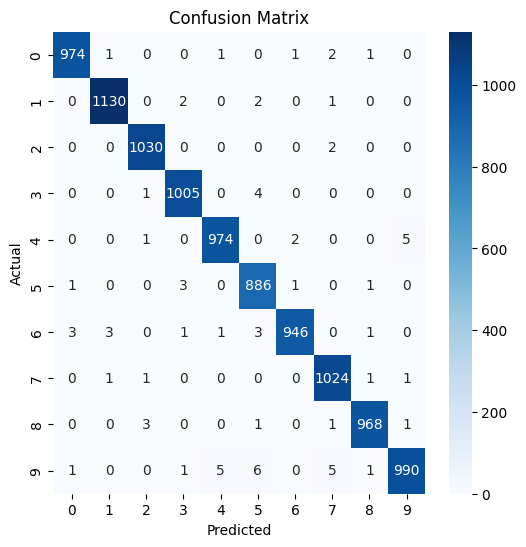

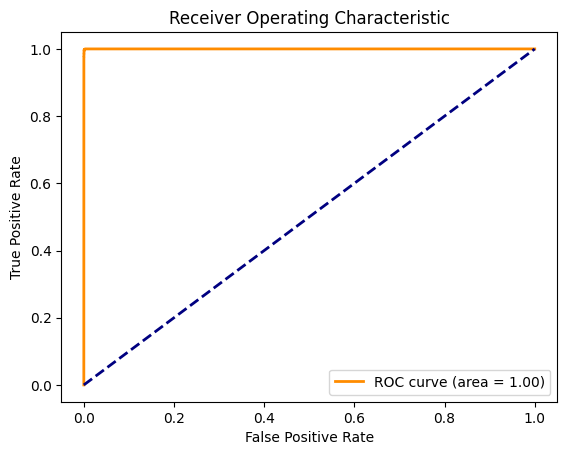


Training CNN on CIFAR-10 Dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.2569 - loss: 1.9940 - val_accuracy: 0.4799 - val_loss: 1.4274
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4675 - loss: 1.4699 - val_accuracy: 0.5110 - val_loss: 1.3491
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5286 - loss: 1.3272 - val_accuracy: 0.5515 - val_loss: 1.2411
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5764 - loss: 1.2013 - val_accuracy: 0.6175 - val_loss: 1.0770
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5981 - loss: 1.1363 - val_accuracy: 0.6386 - val_loss: 1.0145
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6353 - loss: 1.0361 - val_accuracy: 0.6547 - val_loss: 0.9768
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6533 - loss: 0.9906 - val_accuracy: 0.6486 - val_loss: 0.9973
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6688 - loss: 0.9422 - val_accuracy: 0

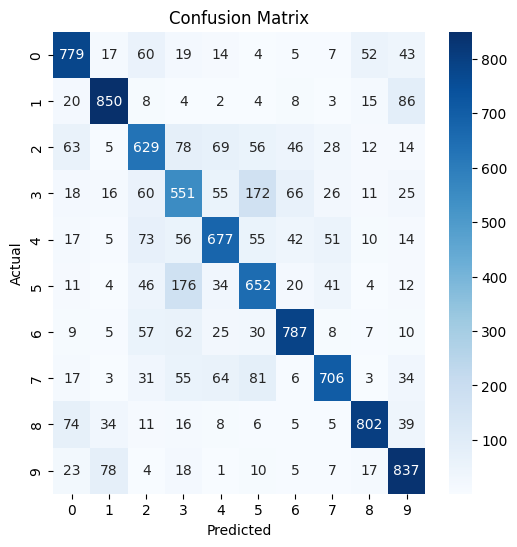

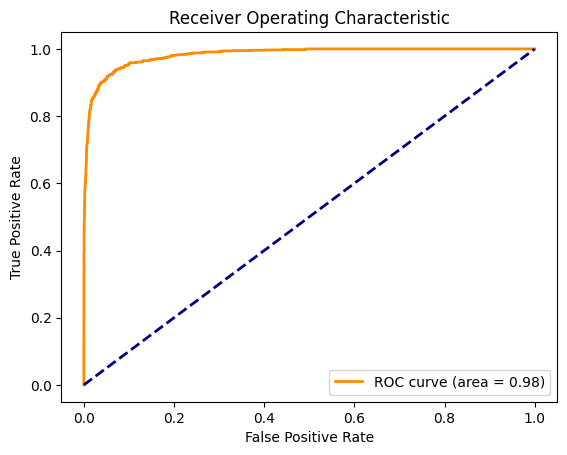

In [ ]:
# Main Execution
if __name__ == '__main__':
    # Task 1: Image Compression
    image_path = '/content/dandw.jpg'  # Replace with your image path

    # DCT-based Compression
    original_dct, compressed_dct = compress_dct(image_path)
    plot_images(original_dct, compressed_dct, title1="Original Image", title2="DCT Compressed Image")

    # Task 2: CNN Training and Evaluation
    print("\nTraining CNN on MNIST Dataset...")
    train_mnist()

    print("\nTraining CNN on CIFAR-10 Dataset...")
    train_cifar10()
